In [1]:
import sys
sys.path.append('../')

In [160]:
from rdkit import Chem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from typing import List, Dict, Callable
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from rdkit.Chem.rdChemReactions import ChemicalReaction

In [40]:
REACTANTS_PATH = "../neopgfs/data/enamine_building_blocks.csv"
REACTIONS_PATH = "../neopgfs/data/rxn_set.txt"
RLV2_DESCRIPTORS_PATH = '../neopgfs/data/descriptors_rlv2.txt'

In [144]:
reactants_df = pd.read_csv(REACTANTS_PATH)
reactants = [Chem.MolFromSmiles(smiles) for smiles in reactants_df.SMILES.values]

In [140]:
reactions_df = pd.read_csv(REACTIONS_PATH, sep='|', header=None)
reactions_df.columns = ['name', 'smarts', 'description']
reactions_df.head()

,name,smarts,description
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",DINGOS Reaction


In [141]:
reactions = [AllChem.ReactionFromSmarts(smarts) for smarts in reactions_df.smarts.values]

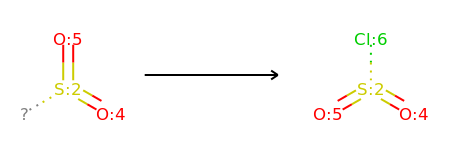

In [143]:
reactions[59]

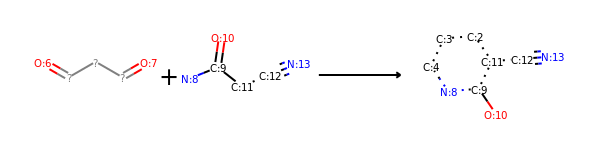

In [145]:
rxn = reactions[15]
rxn

In [150]:
reactants_rxn=list(rxn.GetReactants())

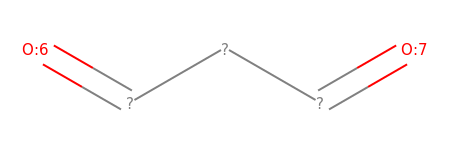

In [151]:
reactants_rxn[0]

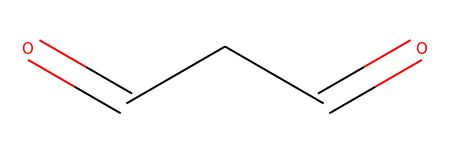

In [153]:
mol = Chem.MolFromSmiles("O=CCC=O")
mol

In [154]:
reactants_rxn[0].HasSubstructMatch(mol)

False

In [155]:
mol.HasSubstructMatch(reactants_rxn[0])

True

In [158]:
rxn.GetNumReactantTemplates()

2

In [159]:
type(rxn)

rdkit.Chem.rdChemReactions.ChemicalReaction

In [184]:
def inverse_reaction(rxn: ChemicalReaction) -> ChemicalReaction:
    rxn_double = ChemicalReaction()
    reactants = list(rxn.GetReactants())
    rxn_double.AddReactantTemplate(reactants[1])
    rxn_double.AddReactantTemplate(reactants[0])
    rxn_double.AddProductTemplate(list(rxn.GetProducts())[0])
    return rxn_double

In [202]:
reactions_df = pd.read_csv(REACTIONS_PATH, sep='|', header=None)
reactions_df.columns = ['name', 'smarts', 'description']
print("Original reaction_df shape = ", reactions_df.shape)

for idx in reactions_df.copy().index:
    rxn = AllChem.ReactionFromSmarts(reactions_df.loc[idx, 'smarts'])
    # Add inverse reaction if rxn has two reactants
    #print(rxn.GetNumReactantTemplates())
    if rxn.GetNumReactantTemplates() == 2:
        rxn_inv = inverse_reaction(rxn)
        new_idx = len(reactions_df)
        reactions_df.loc[new_idx, 'name'] = reactions_df.loc[idx, 'name'] + ' - inverse'
        reactions_df.loc[new_idx, 'smarts'] = AllChem.ReactionToSmarts(rxn_inv)
print("New reactions_df shape=", reactions_df.shape)

Original reaction_df shape =  (64, 3)
New reactions_df shape= (113, 3)


In [210]:
def compute_compatibility_reactions_reactants(level: int, reactions_df: pd.DataFrame, reactants_df: pd.DataFrame) -> np.ndarray:

    out = np.full((len(reactions_df), len(reactants_df)), False)

    for n_reaction, rxn_smarts in enumerate(reactions_df.smarts):
        for n_reactant, mol_smiles in enumerate(reactants_df.SMILES):
            rxn = AllChem.ReactionFromSmarts(rxn_smarts)
            mol = Chem.MolFromSmiles(mol_smiles)


            if rxn.GetNumReactantTemplates() > level:
                template = list(rxn.GetReactants())[level]
                out[n_reaction, n_reactant] = mol.HasSubstructMatch(template)
    return out

In [211]:
rel_r0_rxns = compute_compatibility_reactions_reactants(0, reactions_df, reactants_df)
rel_r1_rxns = compute_compatibility_reactions_reactants(1, reactions_df, reactants_df)

KeyboardInterrupt: 

In [ ]:
rel

In [203]:
out = np.full((len(reactions_df), len(reactants_df)), False)

In [ ]:
rxn.GetNumReactantTemplates()

In [201]:
len(reactions_df)

115

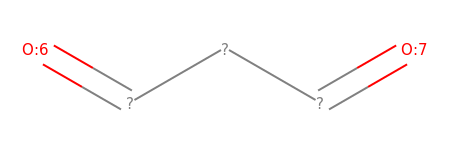

In [175]:
mol2

In [187]:
AllChem.ReactionToSmarts(rxn)

'[O&H1,N&H2,N&H3&+:3]-[C&H2:2]-[C&$(C(-,:[C&X4,c])(-,:[C&X4,c])-,:[C&X4,c]),C&$([C&H1](-,:[C&X4,c])-,:[C&X4,c]),C&$([C&H2]-,:[C&X4,c]),C&$([C&H3]),c&$(c):1]>>[C,c:1][C:2]#[N:4]'

In [157]:
# Invert r

# Compute relationship between reactions and reactants
rel_reactions_reactants = - np.ones((len(reactions_df), len(reactants_df)))
rel_reactions_reactants.shape

(64, 150560)

In [8]:
type(mol)

rdkit.Chem.rdchem.Mol

In [17]:
reactions_df = pd.read_csv('../neopgfs/Data/rxn_set.txt', sep='|', header=None)
reactions_df.columns = ['name', 'smarts', 'desc']
reactions_df.head()

,name,smarts,desc
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",DINGOS Reaction


In [19]:
reactions_df['desc'].value_counts()

DINGOS Reaction    64
Name: desc, dtype: int64

RDKit ERROR: [12:37:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 


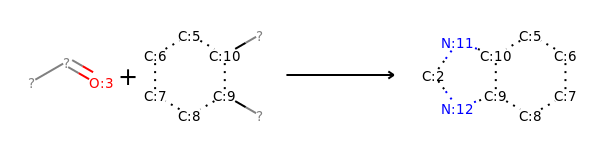

In [21]:
r = AllChem.ReactionFromSmarts(reactions_df.iloc[5,1])
r

In [22]:
type(r)

rdkit.Chem.rdChemReactions.ChemicalReaction